In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io.wavfile import read, write
from numpy.fft import fft, ifft, fftfreq
%matplotlib inline

In [2]:
fs_water, water = read('water_.wav')
water = water[:, 0]

fs_cricket, cricket = read('cricket_.wav')
cricket = cricket[:, 0]

print('Sampling frequency of waterflow : {0}\nSampling frequency of cricket : {1}'.format(fs_water, fs_cricket))

Sampling frequency of waterflow : 48000
Sampling frequency of cricket : 48000


In [3]:
print('No. of samples in waterflow audio : {0}\nNo. of samples in cricket audio : {1}'.format(water.shape[0], cricket.shape[0]))

No. of samples in waterflow audio : 2918063
No. of samples in cricket audio : 4932911


In [4]:
_cricket = cricket[:water.shape[0]]
print('New number of samples in cricket audio : {}'.format(_cricket.shape[0]))

New number of samples in cricket audio : 2918063


In [5]:
bit_depth = 16

time_a = [i/fs_water for i in range(0, water.shape[0])]
len(time_a)

2918063

In [6]:
# Normalization
s_water = water/(2**(bit_depth-1))
s_cricket = _cricket/(2**(bit_depth-1))

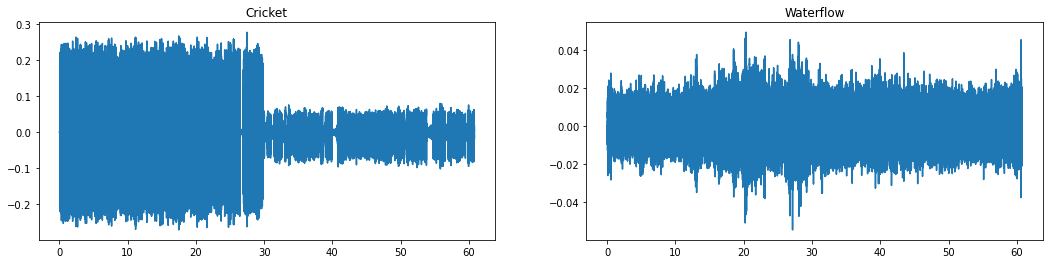

In [7]:
plt.figure(figsize=(18, 4))
plt.subplot(1, 2, 1)
plt.title('Cricket')
plt.plot(time_a, s_cricket)
plt.subplot(1, 2, 2)
plt.title('Waterflow')
plt.plot(time_a, s_water)

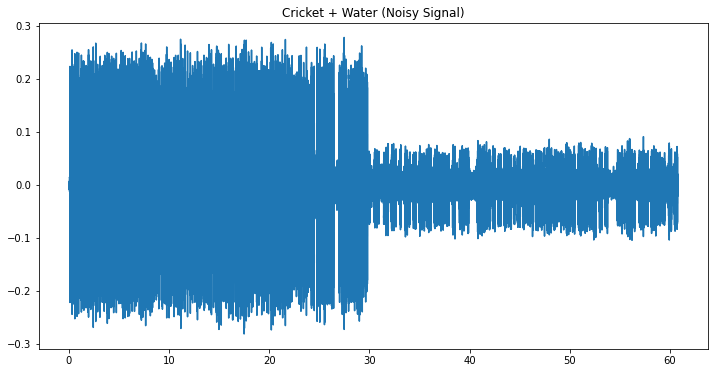

In [8]:
cricket_water = s_cricket + s_water
plt.figure(figsize=(12, 6))
plt.title('Cricket + Water (Noisy Signal)')
plt.plot(time_a, cricket_water)

In [9]:
# Noisy signal
write('cricket_water.wav', fs_water, cricket_water)

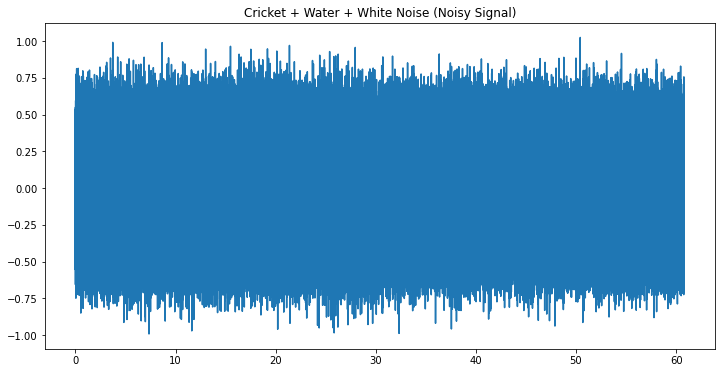

In [10]:
noise = np.random.normal(0, 0.2, water.shape[0])
cricket_water_noise = cricket_water + noise
plt.figure(figsize=(12, 6))
plt.title('Cricket + Water + White Noise (Noisy Signal)')
plt.plot(time_a, cricket_water_noise)


In [11]:
write('cricket_water_noise.wav', fs_water, cricket_water_noise)

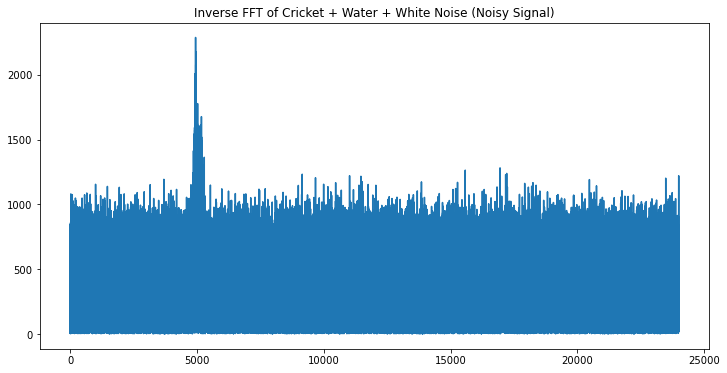

In [12]:
fft_cwn = fft(cricket_water_noise)
freq_cwn = fftfreq(len(fft_cwn), (1.0/fs_water))

plt.figure(figsize=(12, 6))
plt.title('Inverse FFT of Cricket + Water + White Noise (Noisy Signal)')
plt.plot(freq_cwn[range(len(fft_cwn)//2)], abs(fft_cwn[range(len(fft_cwn)//2)]))

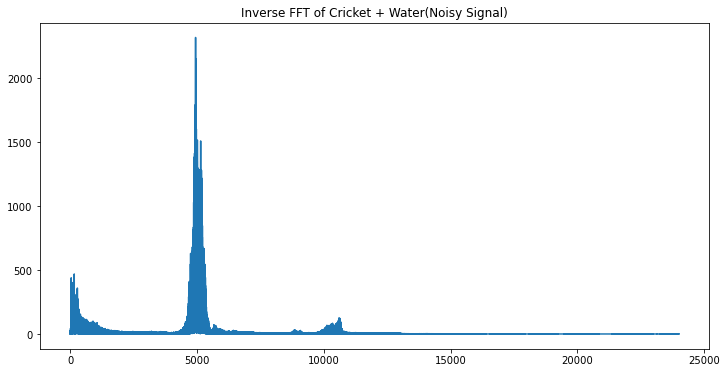

In [13]:
# For IFFT of only cricket + waterflow
fft_cw = fft(cricket_water)
freq_cw = fftfreq(len(fft_cw), (1.0/fs_water))

plt.figure(figsize=(12, 6))
plt.title('Inverse FFT of Cricket + Water(Noisy Signal)')
plt.plot(freq_cw[range(len(fft_cw)//2)], abs(fft_cw[range(len(fft_cw)//2)]))

In [14]:
# Using scipy's bandpass filter
from scipy.signal import butter, lfilter

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y


y = butter_bandpass_filter(cricket_water_noise, 4500, 5500, fs_water)

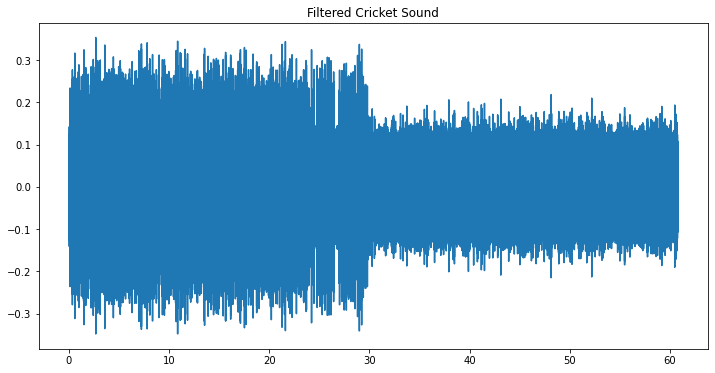

In [15]:
plt.figure(figsize=(12, 6))
plt.title('Filtered Cricket Sound')
plt.plot(time_a, y)

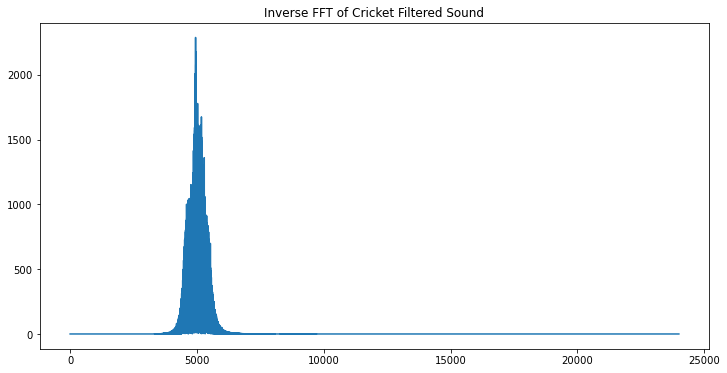

In [16]:
fft_c = fft(y)
freq_c = fftfreq(len(fft_c), (1.0/fs_water))

plt.figure(figsize=(12, 6))
plt.title('Inverse FFT of Cricket Filtered Sound')
plt.plot(freq_c[range(len(fft_c)//2)], abs(fft_c[range(len(fft_c)//2)]))

In [17]:
write('cricket_filtered.wav', fs_water, y)

In [18]:
# Manual zero-ing out required frequencies
# Cricket chirps at around 5000Hz, so we can filter out frequencies below 4.5kHz and above 5.5kHz
def bandpass(fft_cwn, freq_cwn):
    _fft_cwn = fft_cwn.copy()
    _fft_cwn[np.abs(freq_cwn) < 4500] = 0
    _fft_cwn[np.abs(freq_cwn) > 5500] = 0
    ifft_cwn = ifft(_fft_cwn) 
    return ifft_cwn

ifft_cwn = bandpass(fft_cwn, freq_cwn)

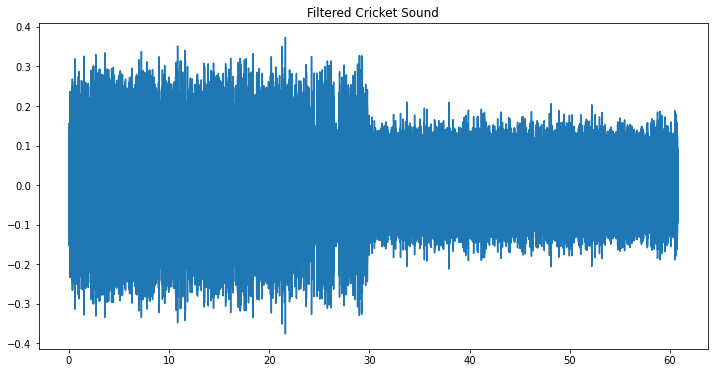

In [19]:
plt.figure(figsize=(12, 6))
plt.title('Filtered Cricket Sound')
plt.plot(time_a, ifft_cwn.real)

In [20]:
write('cricket_filtered_manual.wav', fs_water, ifft_cwn.real)